In [9]:
import numpy as np
from sklearn import datasets
import tensorflow as tf
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
import scipy as sp
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def get_iris_data():
    """ Read the iris data and label/unlabel data points"""
    # load iris data
    iris   = datasets.load_iris()
    data   = iris["data"]
    labels = iris["target"]
    
    # get label 0 and 1, and corresponding data
    labels = labels[labels < 2]
    data = data[np.where(labels < 2)]
    
    # generate random numbers for unlabeling
    rng = np.random.RandomState(42)
    random_unlabeled_points = rng.rand(len(labels)) < 0.5
    masked_labels = np.copy(labels).astype(float)
    
    # keep labels for points that will be unlabeled
    unlabeled_y_sol = np.copy(labels[random_unlabeled_points])

    # unlabel points
    masked_labels[random_unlabeled_points] = 0.5
    
    unlabeled_indices = np.where(random_unlabeled_points)
    
    # separate labeled/unlabeled Y
    unlabeled_y = masked_labels[random_unlabeled_points]
    labeled_y = np.delete(masked_labels,unlabeled_indices)
    
    # separate labeled/unlabeled X
    unlabeled_X = data[unlabeled_indices]
    labeled_X = np.delete(data,unlabeled_indices,axis=0)
    
    return labeled_X, labeled_y, unlabeled_X, unlabeled_y, unlabeled_y_sol

In [3]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [4]:
def get_weights(X):
    
    def get_neighbors(arr,threshold=0.95):
        # index = arr.argsort()[:-5][::-1]
        index = np.where(arr > 0.95)
        arr[index] = 0
        return arr
    
    # use rdf kernel to estimate weights
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    s = np.var(X)
    K = sp.exp(-pairwise_dists ** 2 / s ** 2)
    print(check_symmetric(K))
    np.fill_diagonal(K, 0)
    K = np.apply_along_axis(get_neighbors, 0, K)
    print(check_symmetric(K))
    
    # drop weights under certain threshold to make the graph sparse
    
    
    return K

In [58]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw_networkx(gr,node_size=50,with_labels=False)
    plt.show()

In [59]:
LX, Ly, UX, Uy, Uy_sol = get_iris_data()
weights = get_weights(LX)

True
True


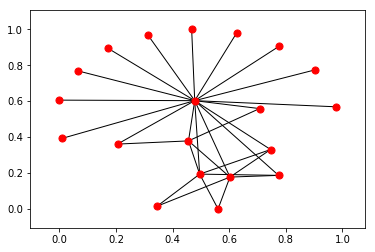

In [67]:
show_graph_with_labels(weights[:20,:20])

In [14]:
# create input matrix 
LY = np.tile(Ly,(Ly.shape[0],1))

# mask diagonal elements
np.fill_diagonal(LY, 0.5)
LY_input = np.concatenate((LY,np.identity(LY.shape[0])),axis=1)

# TODO: shuffle input

In [7]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)


def init_weights(weights_np):
    """ Weight initialization """
    weights = tf.convert_to_tensor(weights_np, np.float32)
    return tf.Variable(weights)

In [115]:
def forwardprop(X, w, T):
    normalized_w = w / tf.reduce_sum(w, axis = 1)
    for i in range(T):
        h = X * normalized_w
        # row normalize y
        normalized_h = h / tf.reduce_sum(h,axis=1)
        X = normalized_h
    return X

In [116]:
# Layer's sizes
T = 2
num_labeled = int(LY_input.shape[1]/2)
x_size = num_labeled # Number of input nodes: number of labeled nodes
h_size = num_labeled # Number of hidden nodes: number of labeled nodes
y_size = num_labeled # Number of outcomes: number of labeled nodes

# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])
one_hot = tf.placeholder("float", shape=[None, x_size])

# Weight initializations
w = init_weights(weights)

# Forward propagation
yhat    = forwardprop(X, w, T)

In [117]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
prediction = sess.run(yhat, feed_dict={X:LY_input[:,:num_labeled] , y:LY_input[:,:num_labeled]})
sess.close()

In [217]:
# Backward propagation: TODO
cost = tf.multiply(y, tf.log(yhat))
#cost = tf.reduce_mean(tf.multiply(one_hot,tf.multiply(y, tf.log(yhat))))
#updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [218]:
# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(1):
    # Train with each example
    for i in range(len(LY)):
        X_ = LY_input[i: i + 1][0][:num_labeled]
        X_ = np.reshape(X_,(1,len(X_)))
        y_ = LY_input[i: i + 1][0][:num_labeled]
        y_ = np.reshape(X_,(1,len(y_)))
        one_hot_ = LY_input[i: i + 1][0][num_labeled:]
        one_hot_ = np.reshape(one_hot_,(1,len(one_hot_)))
#        sess.run(updates, feed_dict={X:X_ , y:y_ , one_hot:one_hot_})
        print(sess.run(cost, feed_dict={X:X_ , y:y_ , one_hot:one_hot_}))
sess.close()

[[       -inf         nan         nan ...,        -inf        -inf
         -inf]
 [       -inf         nan         nan ...,        -inf        -inf
         -inf]
 [       -inf         nan         nan ...,        -inf        -inf
         -inf]
 ..., 
 [       -inf         nan         nan ...,        -inf        -inf
         -inf]
 [       -inf         nan         nan ...,        -inf        -inf
  -0.00776989]
 [       -inf         nan         nan ...,        -inf -0.00776989
         -inf]]
[[        nan        -inf         nan ...,        -inf        -inf
         -inf]
 [        nan        -inf         nan ...,        -inf        -inf
         -inf]
 [        nan -0.35123551         nan ...,        -inf        -inf
         -inf]
 ..., 
 [        nan        -inf         nan ...,        -inf        -inf
         -inf]
 [        nan        -inf         nan ...,        -inf        -inf
  -0.00776989]
 [        nan        -inf         nan ...,        -inf -0.00776989
         -inf]]


In [ ]:

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'labels': masked_labels}, y=masked_labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])